In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
tweets = pd.read_csv("sentiment.csv")

tweets.isnull().values.any()

tweets.shape

(13871, 3)

In [3]:
tweets.head()

,id,text,sentiment
0,1,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,2,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,3,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,4,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,5,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [4]:
tweets['text'][4]

'RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…'

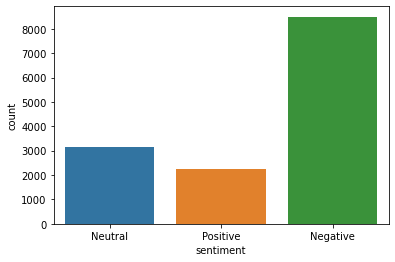

In [5]:
import seaborn as sns

sns.countplot(x='sentiment', data=tweets)

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
X = []
sentences = list(tweets['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
X[4]

'RT DanScavino GOPDebate realDonaldTrump delivered the highest ratings in the history of presidential debates Trump http co '

In [10]:
y = tweets['sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1668200   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 1,678,201
Trainable params: 10,001
Non-trainable params: 1,668,200
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
70/70 [==============================] - 2s 32ms/step - loss: 0.4414 - acc: 0.8301 - val_loss: 0.4011 - val_acc: 0.8410
Epoch 2/6
70/70 [==============================] - 1s 11ms/step - loss: 0.3844 - acc: 0.8482 - val_loss: 0.3792 - val_acc: 0.8577
Epoch 3/6
70/70 [==============================] - 1s 11ms/step - loss: 0.3637 - acc: 0.8542 - val_loss: 0.3705 - val_acc: 0.8586
Epoch 4/6
70/70 [==============================] - 1s 16ms/step - loss: 0.3520 - acc: 0.8535 - val_loss: 0.3690 - val_acc: 0.8559
Epoch 5/6
70/70 [==============================] - 1s 20ms/step - loss: 0.3414 - acc: 0.8591 - val_loss: 0.3634 - val_acc: 0.8536
Epoch 6/6
70/70 [==============================] - 1s 15ms/step - loss: 0.3336 - acc: 0.8579 - val_loss: 0.3608 - val_acc: 0.8577


In [19]:
score = model.evaluate(X_test, y_test, verbose=1)

87/87 [==============================] - 1s 6ms/step - loss: 0.3781 - acc: 0.8548


In [20]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3780757784843445
Test Accuracy: 0.8547747731208801


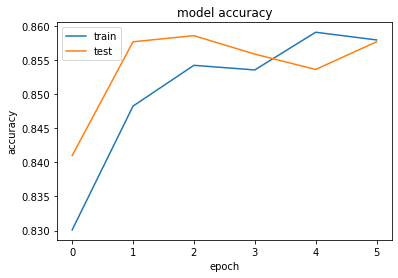

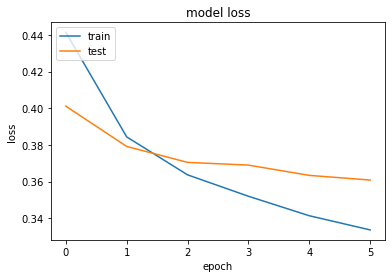

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [22]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1668200   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,668,301
Trainable params: 101
Non-trainable params: 1,668,200
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
70/70 [==============================] - 2s 24ms/step - loss: 0.8774 - acc: 0.5141 - val_loss: 0.4551 - val_acc: 0.8410
Epoch 2/6
70/70 [==============================] - 1s 8ms/step - loss: 0.4502 - acc: 0.8373 - val_loss: 0.4453 - val_acc: 0.8419
Epoch 3/6
70/70 [==============================] - 1s 11ms/step - loss: 0.4488 - acc: 0.8374 - val_loss: 0.4447 - val_acc: 0.8419
Epoch 4/6
70/70 [==============================] - 1s 10ms/step - loss: 0.4480 - acc: 0.8374 - val_loss: 0.4440 - val_acc: 0.8419
Epoch 5/6
70/70 [==============================] - 1s 18ms/step - loss: 0.4472 - acc: 0.8374 - val_loss: 0.4434 - val_acc: 0.8419
Epoch 6/6
87/87 [==============================] - 1s 9ms/step - loss: 0.4424 - acc: 0.8414


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.44238734245300293
Test Accuracy: 0.8414414525032043


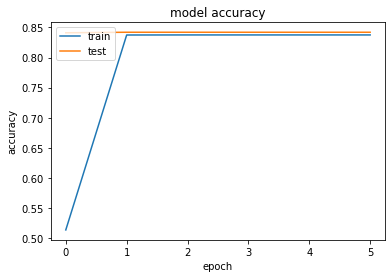

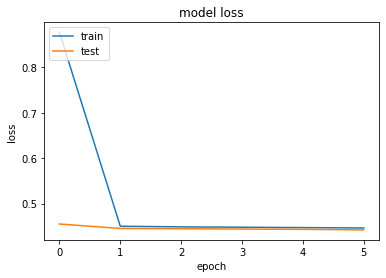

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [27]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)


model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1668200   
_________________________________________________________________
dense_2 (Dense)              (None, 100, 1)            101       
Total params: 1,668,301
Trainable params: 101
Non-trainable params: 1,668,200
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
70/70 [==============================] - 1s 16ms/step - loss: 0.6796 - acc: 0.8027 - val_loss: 0.6504 - val_acc: 0.8315
Epoch 2/6
70/70 [==============================] - 1s 9ms/step - loss: 0.6382 - acc: 0.8327 - val_loss: 0.6261 - val_acc: 0.8386
Epoch 3/6
70/70 [==============================] - 1s 9ms/step - loss: 0.6183 - acc: 0.8348 - val_loss: 0.6082 - val_acc: 0.8396
Epoch 4/6
70/70 [==============================] - 1s 10ms/step - loss: 0.6017 - acc: 0.8357 - val_loss: 0.5924 - val_acc: 0.8401
Epoch 5/6
70/70 [==============================] - 1s 11ms/step - loss: 0.5866 - acc: 0.8362 - val_loss: 0.5778 - val_acc: 0.8404
Epoch 6/6
87/87 [==============================] - 0s 5ms/step - loss: 0.5645 - acc: 0.8404


In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5645161271095276
Test Accuracy: 0.8403888940811157


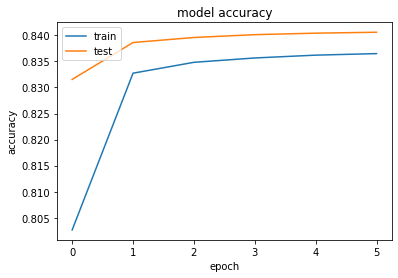

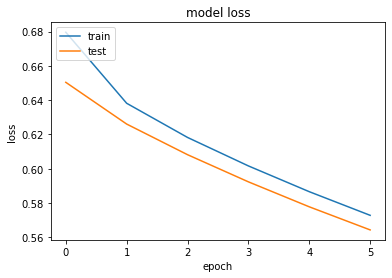

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()